<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 38, 229);">
    <h1 style="font-weight: bold; font-size: 36px;">SVD++ Recommender System </h1>
</div>


In the notebook, we developed an SVD++ recommender system using yelp dataset. SVD++ is an advanced matrix factorization algorithm that improves upon standard SVD by incorporating implicit feedback—such as whether a user interacted with an item, even without rating it. This allows the model to better capture user preferences by factoring in both explicit ratings and underlying behavioral signals, making it especially effective in real-world recommendation scenarios with sparse data.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(9, 229, 9);">
    <h1 style="font-weight: bold; font-size: 36px;">0. Importing Packages and Libraries</h1>
</div>


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # For progress bars



<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(16, 229, 9);">
    <h1 style="font-weight: bold; font-size: 36px;">1.1 Preparing Set/Sample</h1>
</div>

In [15]:
# --------------------------- LOAD DATA --------------------------- #
def loadData(path):
    df = pd.read_csv(path)
    df = df.rename(columns={'business_id': 'item_id', 'stars': 'rating'})
    df = df[['user_id', 'item_id', 'rating']]
    return df

To ensure that the model has enough data to learn meaningful preferences:
- We **remove users** with fewer than 5 ratings because they don't provide enough signal to learn a reliable latent user vector.
- We **remove items** (restaurants) with fewer than 10 ratings because these are too rarely rated to generate meaningful latent features, increasing the risk of overfitting or noise.

In [16]:
# --------------------------- FILTERING --------------------------- #
def filter_active_users_and_items(df, min_user_ratings=5, min_item_ratings=10):
    # Keep track of original counts
    orig_users = df['user_id'].nunique()
    orig_items = df['item_id'].nunique()
    orig_ratings = len(df)
    
    user_counts = df['user_id'].value_counts()
    df = df[df['user_id'].isin(user_counts[user_counts >= min_user_ratings].index)]

    item_counts = df['item_id'].value_counts()
    df = df[df['item_id'].isin(item_counts[item_counts >= min_item_ratings].index)]
    
    # Print stats
    print(f"Filtering stats:")
    print(f"  Users: {orig_users} → {df['user_id'].nunique()} ({df['user_id'].nunique()/orig_users:.1%} kept)")
    print(f"  Items: {orig_items} → {df['item_id'].nunique()} ({df['item_id'].nunique()/orig_items:.1%} kept)")
    print(f"  Ratings: {orig_ratings} → {len(df)} ({len(df)/orig_ratings:.1%} kept)")
    
    return df

## Stratified Sampling for SVD++ on Large Datasets

SVD++ can be computationally intensive, especially on large datasets like Yelp.  
To make experimentation faster and more resource-efficient, we apply **stratified sampling**:

- Instead of random sampling, we **stratify by user activity level** (i.e., number of ratings per user).
- Users are grouped into **low**, **medium**, and **high-frequency bins** based on the 33rd and 66th percentiles of their rating counts.
- This preserves the **distribution of user engagement**, ensuring the sampled data remains representative of the full dataset.

> This approach strikes a balance between **efficiency** and **data integrity**, enabling quicker model iteration without severely compromising performance fidelity.


In [17]:
# --------------------------- STRATIFIED SAMPLING --------------------------- #
def stratified_sampling(df, sample_frac=0.3):
    user_counts = df["user_id"].value_counts()
    
    # Create user rating frequency bins (low, medium, high)
    user_count_percentiles = np.percentile(user_counts, [33, 66])
    bins = [-1, user_count_percentiles[0], user_count_percentiles[1], float('inf')]
    labels = ['low', 'medium', 'high']
    
    df["user_frequency"] = df["user_id"].map(
        user_counts.apply(lambda x: pd.cut([x], bins=bins, labels=labels)[0])
    )
    
    df_sampled, _ = train_test_split(df, test_size=(1 - sample_frac),
                                     stratify=df["user_frequency"], random_state=42)
    return df_sampled.drop(columns=["user_frequency"])

## Data Preprocessing for SVD++ Pipeline

To prepare the dataset for matrix factorization using SVD++, we perform the following key preprocessing steps:

---

### 1. Normalize Ratings

We normalize user ratings by subtracting each user's average rating.  
This centers the ratings around zero and removes user bias (e.g., lenient vs. harsh raters), making comparisons across users more meaningful.

- **Input:** Raw `rating`
- **Output:** `normalized_rating = rating - user_mean`

---

### 2. Create User-Item Matrix

We generate a dense matrix where:
- Rows represent **users**
- Columns represent **items**
- Values represent the (normalized or original) **ratings**

This matrix is the core input for many collaborative filtering models.

- **Input:** DataFrame with `user_id`, `item_id`, and ratings
- **Output:** Pivot table: `user_id × item_id → rating`

---

### 3. Random User Split

To simulate realistic prediction scenarios, we split each user's ratings into:
- **Training set** (e.g., 60%)
- **Validation set** (e.g., 20%)
- **Test set** (e.g., 20%)

The split is:
- Performed **within users** to preserve user-specific patterns
- Randomized (with a fixed seed)
- Requires users to have **at least 5 ratings** to ensure meaningful splits

> This setup mimics real-world recommendation settings where we predict a user's future ratings based on their past behavior.


In [18]:

# --------------------------- NORMALIZE RATINGS --------------------------- #
def normalize_ratings(df):
    """Normalize ratings by subtracting user mean rating"""
    user_means = df.groupby('user_id')['rating'].mean()
    df['normalized_rating'] = df.apply(lambda x: x['rating'] - user_means[x['user_id']], axis=1)
    # Keep both original and normalized ratings
    return df

# --------------------------- USER-ITEM MATRIX --------------------------- #
def create_user_item_matrix(df, rating_column='rating'):
    df_grouped = df.groupby(['user_id', 'item_id'])[rating_column].mean().reset_index()
    return df_grouped.pivot(index="user_id", columns="item_id", values=rating_column)

# --------------------------- SPLIT --------------------------- #
def random_user_split(df, train_ratio=0.6, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    train_data, val_data, test_data = [], [], []
    
    for user, group in df.groupby("user_id"):
        group = group.sample(frac=1, random_state=seed).reset_index(drop=True)
        if len(group) < 5:
            continue
        n = len(group)
        train_end = int(train_ratio * n)
        val_end = int((train_ratio + val_ratio) * n)
        train_data.append(group.iloc[:train_end])
        val_data.append(group.iloc[train_end:val_end])
        test_data.append(group.iloc[val_end:])

    if not train_data or not val_data or not test_data:
        raise ValueError(" Not enough data after filtering. Try lowering min_user_ratings or sample_frac.")

    return pd.concat(train_data), pd.concat(val_data), pd.concat(test_data)

## Matrix Factorization Helper Functions

These utility functions support the implementation and evaluation of the SVD++ algorithm for recommendation.

---

### 1. index_matrix(matrix)

Creates a binary indicator matrix `I` from the user-item interaction matrix `R`:
- Sets all positive ratings to 1
- Keeps zeros as 0

This is commonly used in matrix factorization to represent observed vs. missing interactions.

---

### 2. batch_predictions(P, Q, Y, B_U, B_I, avg, user_indices, item_indices, item_by_users)

Efficient, vectorized prediction function for SVD++.

For each user-item pair:
- Computes implicit feedback-adjusted user latent vector `pPlusY`
- Incorporates global average (`avg`), user bias (`B_U[u]`), and item bias (`B_I[item]`)
- Predicts rating using dot product between user and item latent vectors

Handles users with no implicit feedback by falling back to a baseline prediction:


In [19]:

# --------------------------- MATRIX FACTORIZATION HELPERS --------------------------- #
def index_matrix(matrix):
    I = matrix.copy()
    I[I > 0] = 1
    I[I == 0] = 0
    return I

# Vectorized prediction function for efficiency
def batch_predictions(P, Q, Y, B_U, B_I, avg, user_indices, item_indices, item_by_users):
    n_predictions = len(user_indices)
    predictions = np.zeros(n_predictions)
    
    for i in range(n_predictions):
        u, item = user_indices[i], item_indices[i]
        n_u = len(item_by_users.get(u, []))
        if n_u == 0:
            predictions[i] = avg + B_U[u] + B_I[item]
            continue
            
        pPlusY = P[:, u] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[u]], axis=0)
        predictions[i] = avg + B_U[u] + B_I[item] + np.dot(pPlusY, Q[:, item])
        
    return predictions

def rmse(R, user_indices, item_indices, actual_ratings, avg, Q, P, Y, B_U, B_I, item_by_users):
    """Calculate RMSE using vectorized operations"""
    if len(user_indices) == 0:
        return np.nan
        
    predictions = batch_predictions(P, Q, Y, B_U, B_I, avg, user_indices, item_indices, item_by_users)
    return np.sqrt(mean_squared_error(actual_ratings, predictions))


## Training Function for SVD++ Matrix Factorization

This function implements the **SVD++ algorithm**, an advanced matrix factorization method that incorporates both **explicit ratings** and **implicit feedback**. It is optimized for performance, interpretability, and flexibility.

---

### Function: `train_svdpp(...)`

#### **Inputs**:
- `train_matrix`: Pandas DataFrame of user-item ratings (training set)
- `val_matrix`: DataFrame for validation set, same structure as train
- `numFactors`: Dimensionality of latent feature space (default=20)
- `gamma`: Initial learning rate (default=0.01)
- `reg`: Regularization parameter to prevent overfitting (default=0.1)
- `num_epochs`: Max number of training iterations (default=100)
- `patience`: Number of epochs without improvement before early stopping
- `verbose`: Whether to print epoch results (default=False)
- `use_tqdm`: Whether to display training progress bar (default=True)

---

### **Key Features**:

- **Implicit Feedback Support**:
  - Uses a matrix `Y` to capture implicit interactions (e.g., presence of rating, regardless of value)
  - Aggregated into the prediction using normalized sum of item embeddings

- **Bias Terms**:
  - Learns global bias (`avg`), user biases (`B_U`), and item biases (`B_I`)

- **Adaptive Learning Rate**:
  - Applies decay (`decay_factor=0.9`) to learning rate over time
  - Prevents overshooting during training

- **Weight Initialization**:
  - Uses **Xavier/Glorot initialization** to balance the scale of initial latent vectors

- **Early Stopping**:
  - Stops training if validation RMSE doesn’t improve for `patience` epochs

---

### **Returns**:
- `train_errors`: List of RMSE values across training epochs
- `val_errors`: List of RMSE values across validation epochs
- `model_snapshot`: Tuple containing:
  - `P`: user latent factors
  - `Q`: item latent factors
  - `Y`: implicit feedback matrix
  - `B_U`, `B_I`: bias terms
  - `avg`: global mean
  - `item_by_users`: dictionary mapping users to interacted items
  - `user_map`, `item_map`: ID-to-index mapping for users/items

---

This training function supports rapid prototyping while maintaining robust generalization through regularization and early stopping. It's ideal for experiments involving implicit + explicit feedback on large-scale datasets.


In [20]:

# --------------------------- TRAINING SVD++ --------------------------- #
def train_svdpp(train_matrix, val_matrix, numFactors=20, gamma=0.01, reg=0.1, 
                num_epochs=100, patience=5, verbose=False, use_tqdm=True):
    users = train_matrix.index.tolist()
    items = train_matrix.columns.tolist()
    user_map = {u: i for i, u in enumerate(users)}
    item_map = {v: j for j, v in enumerate(items)}
    n_users, n_items = len(users), len(items)

    R = train_matrix.fillna(0).astype(float).values
    V = val_matrix.fillna(0).astype(float).values
    
    # Calculate global average
    avg = R[R > 0].mean()
    
    # Create dictionaries mapping users to their rated items
    item_by_users = {u: list(np.where(R[u] > 0)[0]) for u in range(n_users)}
    
    # Extract training and validation data points
    train_users, train_items = R.nonzero()
    train_ratings = R[train_users, train_items]
    
    val_users, val_items = V.nonzero()
    val_ratings = V[val_users, val_items]

    # Initialize model parameters with Xavier/Glorot initialization
    # This helps with convergence by setting proper initial scale
    P = np.random.normal(0, 1/np.sqrt(numFactors), (numFactors, n_users))
    Q = np.random.normal(0, 1/np.sqrt(numFactors), (numFactors, n_items))
    Y = np.random.normal(0, 1/np.sqrt(numFactors), (n_items, numFactors))
    B_U = np.zeros(n_users)
    B_I = np.zeros(n_items)

    train_errors, val_errors = [], []
    best_val_rmse = float("inf")
    best_model_snapshot = None
    best_epoch = 0
    
    # Use adaptive learning rate
    initial_gamma = gamma
    decay_factor = 0.9
    min_gamma = 0.001

    # Set up progress bar for epochs
    epoch_iterator = tqdm(range(num_epochs)) if use_tqdm else range(num_epochs)
    
    for epoch in epoch_iterator:
        # Shuffle training data for each epoch
        indices = np.arange(len(train_users))
        np.random.shuffle(indices)
        train_users_shuffled = train_users[indices]
        train_items_shuffled = train_items[indices]
        train_ratings_shuffled = train_ratings[indices]
        
        # Reduce learning rate over time
        current_gamma = max(initial_gamma * (decay_factor ** epoch), min_gamma)
        
        for i in range(len(train_users_shuffled)):
            u = train_users_shuffled[i]
            item = train_items_shuffled[i]
            r = train_ratings_shuffled[i]
            
            n_u = len(item_by_users[u])
            if n_u == 0:
                continue
                
            # Calculate current prediction
            pPlusY = P[:, u] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[u]], axis=0)
            pred = avg + B_U[u] + B_I[item] + np.dot(pPlusY, Q[:, item])
            
            # Calculate error
            err = r - pred
            
            # Update parameters with regularization
            P[:, u] += current_gamma * (err * Q[:, item] - reg * P[:, u])
            Q[:, item] += current_gamma * (err * pPlusY - reg * Q[:, item])
            
            # Update implicit feedback factors
            Y_update = current_gamma * (err * (1 / np.sqrt(n_u)) * Q[:, item] - reg * Y[item_by_users[u]])
            Y[item_by_users[u]] += Y_update
            
            # Update biases
            B_U[u] += current_gamma * (err - reg * B_U[u])
            B_I[item] += current_gamma * (err - reg * B_I[item])

        # Calculate errors
        train_rmse = rmse(R, train_users, train_items, train_ratings, 
                         avg, Q, P, Y, B_U, B_I, item_by_users)
        val_rmse = rmse(V, val_users, val_items, val_ratings, 
                       avg, Q, P, Y, B_U, B_I, item_by_users)

        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

        if verbose:
            print(f"Epoch {epoch+1} - Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, LR: {current_gamma:.6f}")
        elif use_tqdm:
            epoch_iterator.set_description(f"Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

        # Save best model
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_epoch = epoch
            best_model_snapshot = (P.copy(), Q.copy(), Y.copy(), B_U.copy(), B_I.copy())
        # Early stopping
        elif epoch - best_epoch >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break

    P, Q, Y, B_U, B_I = best_model_snapshot
    return train_errors, val_errors, (P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map)

## Plotting the Learning Curve for SVD++ Training

The learning curve visually tracks the model’s performance across epochs, helping to identify:

- Training progress
- Convergence behavior
- Overfitting or underfitting
- Best epoch based on validation RMSE

---

### Function: `plot_learning_curve(train_errors, val_errors, best_params)`

#### **Inputs**:
- `train_errors`: List of RMSE values from training data per epoch
- `val_errors`: List of RMSE values from validation data per epoch
- `best_params`: Dictionary of best hyperparameters, e.g.:
  ```python
  best_params = {
      'factors': 20,
      'gamma': 0.01,
      'reg': 0.1
  }


In [21]:
# --------------------------- PLOT LEARNING CURVE --------------------------- #
def plot_learning_curve(train_errors, val_errors, best_params):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label='Train RMSE', color='blue', linewidth=2)
    plt.plot(val_errors, label='Val RMSE', color='red', linewidth=2)
    
    # Add best validation point
    best_epoch = np.argmin(val_errors)
    plt.scatter(best_epoch, val_errors[best_epoch], color='green', s=100, 
                label=f'Best Val RMSE: {val_errors[best_epoch]:.4f}')
    
    plt.title(f"SVD++ Learning Curve\n(factors={best_params['factors']}, γ={best_params['gamma']}, λ={best_params['reg']})",
             fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Add vertical line at best epoch
    plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5)
    
    plt.show()

## Hyperparameter Tuning with Cross-Validation (SVD++)

This function performs **grid search cross-validation** to find the optimal hyperparameters for the SVD++ model.

It explores combinations of:
- `factors`: Number of latent features
- `gamma`: Learning rate
- `reg`: Regularization strength

---

### Function: `cross_validate_hyperparams(df, normalized=True)`

#### **Inputs**:
- `df`: Preprocessed DataFrame containing `user_id`, `item_id`, and either `rating` or `normalized_rating`
- `normalized` (default=True): Whether to use the `normalized_rating` column or the original `rating` column

---

### **Key Features**:

- **Grid Search**:
  - Exhaustively searches a grid of hyperparameter combinations:
    - `factors`: [10, 20, 30]
    - `gamma`: [0.005, 0.01, 0.02]
    - `reg`: [0.05, 0.1, 0.2]

- **3-Fold Cross-Validation**:
  - Splits users into 3 folds using `KFold`
  - Ensures the splits are based on **user IDs**, maintaining user histories in train/val sets

- **Matrix Creation**:
  - Constructs user-item matrices for train and validation data
  - Keeps only common items across train/validation to avoid unseen items

- **Robust Error Handling**:
  - Catches and reports training exceptions gracefully

- **Evaluation**:
  - Tracks and stores validation RMSE for each hyperparameter combo
  - Averages performance across folds to select the best configuration

---

### **Returns**:
- `best_params`: Dictionary with the best hyperparameters found:
  ```python
  {
      'factors': int,
      'gamma': float,
      'reg': float
  }


In [22]:
def cross_validate_hyperparams(df, normalized=True):
    """
    Performs cross-validation on the given dataframe for SVD++ hyperparams.
    """
    from sklearn.model_selection import KFold
    
    # 1) Choose which rating column to use
    rating_col = 'normalized_rating' if normalized else 'rating'
    
    # 2) Define smaller hyperparameter grid
    param_grid = {
        'factors': [10, 20],    # fewer factor sizes
        'gamma': [0.01],        # single learning rate
        'reg': [0.05, 0.1]      # fewer regularization options
    }
    
    print("Searching through fewer hyperparameter combinations for faster training...")

    # 3) Set up KFold to split *user IDs*, not individual rows
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    all_users = df['user_id'].unique()

    results = []

    for fold, (train_users_idx, val_users_idx) in enumerate(kf.split(all_users)):
        print(f"\n--- Fold {fold+1}/2 ---")
        
        # --------------------------------------
        # 3a) Create actual train_df, val_df
        # --------------------------------------
        # Identify which user IDs go in train vs. val
        train_user_ids = all_users[train_users_idx]
        val_user_ids   = all_users[val_users_idx]

        # Subset the main dataframe
        train_df = df[df['user_id'].isin(train_user_ids)]
        val_df   = df[df['user_id'].isin(val_user_ids)]
        
        # If either set is empty, skip
        if len(train_df) == 0 or len(val_df) == 0:
            print("Skipping this fold because train or val split is empty.")
            continue
        
        # --------------------------------------
        # 3b) Create the user-item matrices
        # --------------------------------------
        train_matrix = create_user_item_matrix(train_df, rating_col)
        val_matrix   = create_user_item_matrix(val_df, rating_col)

        # Optionally, restrict to common items in both train & val
        common_items = train_matrix.columns.intersection(val_matrix.columns)
        train_matrix = train_matrix[common_items]
        val_matrix   = val_matrix[common_items]
        
        # If no overlapping items, skip
        if train_matrix.shape[1] == 0 or val_matrix.shape[1] == 0:
            print("No overlapping items between train and val in this fold, skipping.")
            continue

        # --------------------------------------
        # 3c) Grid search over param_grid
        # --------------------------------------
        for f in param_grid['factors']:
            for g in param_grid['gamma']:
                for r in param_grid['reg']:
                    print(f"  Training with factors={f}, gamma={g}, reg={r}")
                    
                    try:
                        # We do a short training for speed
                        _, val_rmse_list, _ = train_svdpp(
                            train_matrix, val_matrix,
                            numFactors=f, gamma=g, reg=r,
                            num_epochs=20,   # reduced for quicker runs
                            patience=2,      # reduced
                            verbose=False,
                            use_tqdm=False   # or True if you prefer progress bars
                        )
                        
                        # The final val RMSE is the minimum over the epochs
                        final_val_rmse = min(val_rmse_list)
                        
                        # Add to results
                        results.append({
                            'fold': fold,
                            'factors': f,
                            'gamma': g,
                            'reg': r,
                            'val_rmse': final_val_rmse
                        })
                        
                        print(f"    Val RMSE: {final_val_rmse:.4f}")
                    
                    except Exception as e:
                        print(f"    Error: {e} -- skipping combo.")

    # -------------------------------
    # After all folds + combos:
    # -------------------------------
    if len(results) == 0:
        raise RuntimeError(
            "No successful runs were recorded. Possibly all folds or combos were skipped."
        )
    
    # Convert results to dataframe
    results_df = pd.DataFrame(results)

    # Calculate average RMSE across folds for each param combo
    avg_results = (
        results_df.groupby(['factors', 'gamma', 'reg'])['val_rmse']
        .mean()
        .reset_index()
    )
    
    # Find best parameters
    best_idx = avg_results['val_rmse'].idxmin()
    best_row = avg_results.loc[best_idx]
    best_params = {
        'factors': int(best_row['factors']),
        'gamma': float(best_row['gamma']),
        'reg': float(best_row['reg'])
    }
    
    print("\n===== Cross-Validation Results =====")
    print("Top 5 parameter combinations by val_rmse:")
    print(avg_results.sort_values('val_rmse').head(5))
    
    print("\n✅ Best Hyperparameters:")
    print(f"  Factors: {best_params['factors']}")
    print(f"  Learning rate (gamma): {best_params['gamma']}")
    print(f"  Regularization (lambda): {best_params['reg']}")
    print(f"  Average validation RMSE: {best_row['val_rmse']:.4f}")
    
    return best_params


## Training the Final SVD++ Model

After selecting the optimal hyperparameters via cross-validation, this function trains the **final SVD++ model** on a larger portion of the dataset and evaluates its generalization on a held-out test set.

---

### Function: `train_final_model(df, best_params, normalized=True)`

#### **Inputs**:
- `df`: Full ratings DataFrame with columns like `user_id`, `item_id`, and rating values
- `best_params`: Dictionary containing the best hyperparameters from tuning:
  ```python
  {
      'factors': int,
      'gamma': float,
      'reg': float
  }


In [23]:

# --------------------------- TRAIN FINAL MODEL --------------------------- #
def train_final_model(df, best_params, normalized=True):
    # Prepare rating column
    rating_col = 'normalized_rating' if normalized else 'rating'
    
    # Split data
    train_df, val_df, test_df = random_user_split(df, train_ratio=0.7, val_ratio=0.15)
    
    # Create matrices
    train_matrix = create_user_item_matrix(train_df, rating_column=rating_col)
    val_matrix = create_user_item_matrix(val_df, rating_column=rating_col)
    test_matrix = create_user_item_matrix(test_df, rating_column=rating_col)
    
    print("Training final model with best parameters...")
    train_errors, val_errors, model = train_svdpp(
        train_matrix, val_matrix,
        numFactors=best_params['factors'],
        gamma=best_params['gamma'],
        reg=best_params['reg'],
        num_epochs=200,
        patience=10,
        verbose=True,
        use_tqdm=True
    )
    
    # Plot learning curve
    plot_learning_curve(train_errors, val_errors, best_params)
    
    # Get train and validation combined for final evaluation
    train_val_matrix = train_matrix.combine_first(val_matrix)
    
    return model, train_val_matrix, test_matrix


In [24]:

# --------------------------- PRECISION / RECALL @K --------------------------- #
def evaluate_metrics_at_k(model, train_val_matrix, test_matrix, ks=[5, 10, 20], normalized=True):
    P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map = model
    reverse_item_map = {v: k for k, v in item_map.items()}
    reverse_user_map = {v: k for k, v in user_map.items()}
    
    # Initialize metrics storage
    metrics = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in ks}
    
    # Use tqdm for progress tracking
    total_users = len(item_by_users)
    progress_bar = tqdm(total=total_users, desc="Evaluating recommendations")

    for user_index in item_by_users:
        user_id = reverse_user_map[user_index]
        if user_id not in test_matrix.index:
            progress_bar.update(1)
            continue
            
        # Get true items from test set
        true_items = test_matrix.loc[user_id].dropna()
        if len(true_items) == 0:
            progress_bar.update(1)
            continue
            
        # Get relevant and irrelevant items
        seen_items = set(np.where(train_val_matrix.loc[user_id].fillna(0).values > 0)[0])
        all_items = set(range(Q.shape[1]))
        unseen_items = list(all_items - seen_items)
        
        # Skip if user has no rated items
        n_u = len(item_by_users[user_index])
        if n_u == 0:
            progress_bar.update(1)
            continue
            
        # Calculate user representation
        pPlusY = P[:, user_index] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[user_index]], axis=0)
        
        # Get predictions for all unseen items
        preds = []
        for i in unseen_items:
            item_id = reverse_item_map[i]
            score = avg + B_U[user_index] + B_I[i] + np.dot(pPlusY, Q[:, i])
            preds.append((item_id, score))
        
        # Sort predictions by score
        sorted_preds = sorted(preds, key=lambda x: x[1], reverse=True)
        
        # Calculate metrics for each k
        for k in ks:
            # Get top-k recommendations
            top_k_items = [item for item, _ in sorted_preds[:k]]
            
            # Find items that are in both top-k and test set
            hit_items = set(top_k_items) & set(true_items.index)
            
            # Calculate precision and recall
            precision = len(hit_items) / k if k > 0 else 0
            recall = len(hit_items) / len(true_items) if len(true_items) > 0 else 0
            
            # Calculate NDCG
            # Create a relevance array where 1 = relevant item in top-k
            relevance = np.zeros(k)
            for i, item in enumerate(top_k_items):
                if item in true_items.index:
                    # Use the true rating as relevance score (normalized to 0-1)
                    if normalized:
                        # For normalized ratings, shift to make all positive
                        relevance[i] = (true_items[item] + 5) / 10  # Assuming -5 to 5 range
                    else:
                        # For regular ratings (e.g., 1-5 scale)
                        relevance[i] = true_items[item] / 5
            
            # Calculate DCG
            dcg = np.sum(relevance / np.log2(np.arange(2, k + 2)))
            
            # Calculate ideal DCG (items sorted by relevance)
            ideal_relevance = np.zeros(k)
            true_sorted = true_items.sort_values(ascending=False)
            for i in range(min(k, len(true_sorted))):
                if normalized:
                    ideal_relevance[i] = (true_sorted.iloc[i] + 5) / 10
                else:
                    ideal_relevance[i] = true_sorted.iloc[i] / 5
            
            idcg = np.sum(ideal_relevance / np.log2(np.arange(2, k + 2)))
            
            # Calculate NDCG
            ndcg = dcg / idcg if idcg > 0 else 0
            
            # Store metrics
            metrics[k]['precision'].append(precision)
            metrics[k]['recall'].append(recall)
            metrics[k]['ndcg'].append(ndcg)
        
        progress_bar.update(1)
    
    progress_bar.close()
    
    # Calculate average metrics
    results = {}
    for k in ks:
        results[f'precision@{k}'] = np.mean(metrics[k]['precision'])
        results[f'recall@{k}'] = np.mean(metrics[k]['recall'])
        results[f'ndcg@{k}'] = np.mean(metrics[k]['ndcg'])
    
    # Display results
    print("\n📊 Evaluation Results:")
    for k in ks:
        print(f"\nMetrics @{k}:")
        print(f"  Precision: {results[f'precision@{k}']:.4f}")
        print(f"  Recall:    {results[f'recall@{k}']:.4f}")
        print(f"  NDCG:      {results[f'ndcg@{k}']:.4f}")
    
    return results

## SVD++ Recommendation System Pipeline

This is the end-to-end execution pipeline for building, training, and evaluating an SVD++-based recommendation system on Yelp restaurant reviews.

---

### Steps:

1. **Load and Preprocess Data**:
   - Reads in the Yelp dataset from a CSV file
   - Applies **stratified sampling** to reduce dataset size while preserving user activity distribution
   - Filters out:
     - Users with fewer than 5 ratings
     - Items with fewer than 10 ratings

2. **Normalize Ratings**:
   - Ratings are normalized per user by subtracting the user’s mean rating
   - This reduces user-specific biases and improves collaborative filtering performance

3. **Hyperparameter Tuning with Cross-Validation**:
   - Performs 3-fold cross-validation on a grid of hyperparameters:
     - `factors` (latent dimensions)
     - `gamma` (learning rate)
     - `reg` (regularization)
   - Selects the best configuration based on **average validation RMSE**

4. **Train Final Model**:
   - Retrains the SVD++ model using the best hyperparameters on a 70/15/15 user split (train/val/test)
   - Visualizes training and validation learning curves
   - Returns the final trained model and relevant data matrices

5. **Evaluate Top-K Recommendation Metrics**:
   - Evaluates the model’s recommendation quality on the held-out test set
   - Computes top-K metrics (e.g., Precision@K, Recall@K, NDCG@K) for K ∈ {5, 10, 20}

---

### Final Output:
- Best hyperparameters (`factors`, `gamma`, `reg`)
- Trained model components
- Top-K performance metrics on unseen data


Loading and preprocessing data...
Filtering stats:
  Users: 583581 → 36036 (6.2% kept)
  Items: 34524 → 10687 (31.0% kept)
  Ratings: 1132191 → 309590 (27.3% kept)

Normalizing ratings...

Performing hyperparameter tuning with cross-validation...
Searching through fewer hyperparameter combinations for faster training...

--- Fold 1/2 ---
  Training with factors=10, gamma=0.01, reg=0.05
    Val RMSE: 1.0545
  Training with factors=10, gamma=0.01, reg=0.1
    Val RMSE: 1.0407
  Training with factors=20, gamma=0.01, reg=0.05
    Val RMSE: 1.0355
  Training with factors=20, gamma=0.01, reg=0.1
    Val RMSE: 1.0261

--- Fold 2/2 ---
  Training with factors=10, gamma=0.01, reg=0.05
    Val RMSE: 1.0486
  Training with factors=10, gamma=0.01, reg=0.1
    Val RMSE: 1.0373
  Training with factors=20, gamma=0.01, reg=0.05
    Val RMSE: 1.0321
  Training with factors=20, gamma=0.01, reg=0.1
    Val RMSE: 1.0235

===== Cross-Validation Results =====
Top 5 parameter combinations by val_rmse:
   fac

python(70227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  0%|          | 1/200 [00:03<10:41,  3.22s/it]

Epoch 1 - Train RMSE: 1.0677, Val RMSE: 1.1760, LR: 0.010000


  1%|          | 2/200 [00:06<10:46,  3.27s/it]

Epoch 2 - Train RMSE: 0.9867, Val RMSE: 1.1437, LR: 0.009000


  2%|▏         | 3/200 [00:09<10:39,  3.25s/it]

Epoch 3 - Train RMSE: 0.9371, Val RMSE: 1.1276, LR: 0.008100


  2%|▏         | 4/200 [00:13<10:37,  3.25s/it]

Epoch 4 - Train RMSE: 0.9028, Val RMSE: 1.1188, LR: 0.007290


  2%|▎         | 5/200 [00:16<10:30,  3.23s/it]

Epoch 5 - Train RMSE: 0.8772, Val RMSE: 1.1139, LR: 0.006561


  3%|▎         | 6/200 [00:19<10:26,  3.23s/it]

Epoch 6 - Train RMSE: 0.8573, Val RMSE: 1.1112, LR: 0.005905


  4%|▎         | 7/200 [00:22<10:23,  3.23s/it]

Epoch 7 - Train RMSE: 0.8412, Val RMSE: 1.1096, LR: 0.005314


  4%|▍         | 8/200 [00:25<10:17,  3.22s/it]

Epoch 8 - Train RMSE: 0.8279, Val RMSE: 1.1088, LR: 0.004783


  4%|▍         | 9/200 [00:29<10:13,  3.21s/it]

Epoch 9 - Train RMSE: 0.8167, Val RMSE: 1.1084, LR: 0.004305


  5%|▌         | 10/200 [00:32<10:10,  3.21s/it]

Epoch 10 - Train RMSE: 0.8072, Val RMSE: 1.1083, LR: 0.003874


  6%|▌         | 11/200 [00:35<10:05,  3.21s/it]

Epoch 11 - Train RMSE: 0.7990, Val RMSE: 1.1084, LR: 0.003487


  6%|▌         | 12/200 [00:38<10:03,  3.21s/it]

Epoch 12 - Train RMSE: 0.7919, Val RMSE: 1.1086, LR: 0.003138


  6%|▋         | 13/200 [00:41<09:59,  3.20s/it]

Epoch 13 - Train RMSE: 0.7857, Val RMSE: 1.1088, LR: 0.002824


  7%|▋         | 14/200 [00:45<09:56,  3.21s/it]

Epoch 14 - Train RMSE: 0.7802, Val RMSE: 1.1091, LR: 0.002542


  8%|▊         | 15/200 [00:48<09:53,  3.21s/it]

Epoch 15 - Train RMSE: 0.7755, Val RMSE: 1.1094, LR: 0.002288


  8%|▊         | 16/200 [00:51<09:50,  3.21s/it]

Epoch 16 - Train RMSE: 0.7712, Val RMSE: 1.1097, LR: 0.002059


  8%|▊         | 17/200 [00:54<09:48,  3.21s/it]

Epoch 17 - Train RMSE: 0.7675, Val RMSE: 1.1099, LR: 0.001853


  9%|▉         | 18/200 [00:58<09:48,  3.23s/it]

Epoch 18 - Train RMSE: 0.7642, Val RMSE: 1.1102, LR: 0.001668


 10%|▉         | 19/200 [01:01<09:43,  3.22s/it]

Epoch 19 - Train RMSE: 0.7612, Val RMSE: 1.1105, LR: 0.001501


 10%|▉         | 19/200 [01:04<10:13,  3.39s/it]

Epoch 20 - Train RMSE: 0.7586, Val RMSE: 1.1107, LR: 0.001351
Early stopping at epoch 20


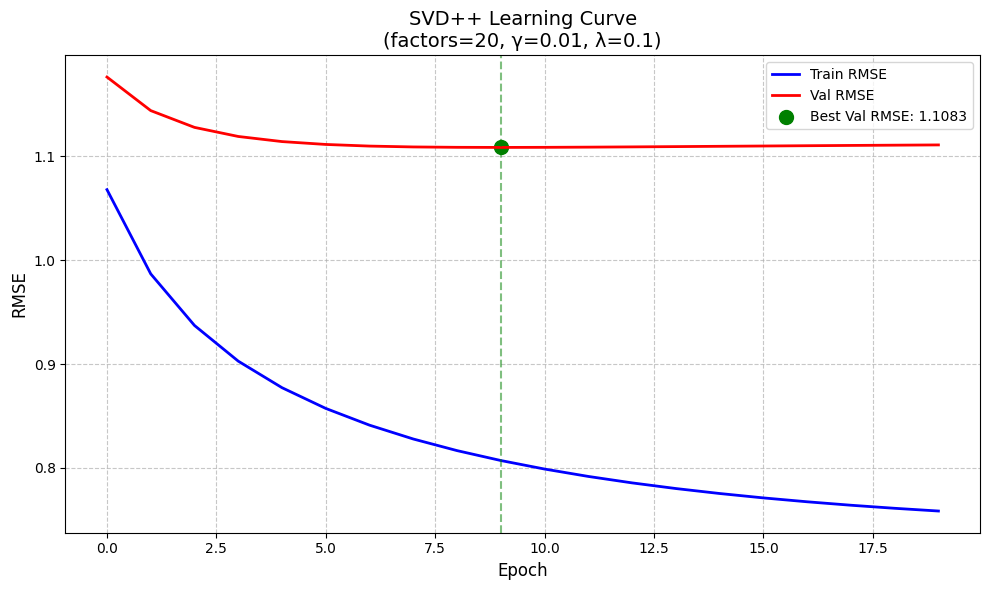


Evaluating recommendation quality...


Evaluating recommendations: 100%|██████████| 27769/27769 [03:26<00:00, 134.42it/s]


📊 Evaluation Results:

Metrics @5:
  Precision: 0.0001
  Recall:    0.0003
  NDCG:      0.0002

Metrics @10:
  Precision: 0.0001
  Recall:    0.0006
  NDCG:      0.0003

Metrics @20:
  Precision: 0.0001
  Recall:    0.0013
  NDCG:      0.0006


In [25]:

# --------------------------- MAIN --------------------------- #
if __name__ == "__main__":
    # Load and preprocess
    print("Loading and preprocessing data...")
    df = loadData('/Users/mandidisha/Downloads/SDMmandi/Yelp/restaurant_reviews.csv')
    df = stratified_sampling(df, sample_frac=0.3)
    df = filter_active_users_and_items(df, min_user_ratings=5, min_item_ratings=10)
    
    # Normalize ratings
    print("\nNormalizing ratings...")
    df = normalize_ratings(df)
    
    # Hyperparameter tuning with cross-validation
    print("\nPerforming hyperparameter tuning with cross-validation...")
    best_params = cross_validate_hyperparams(df, normalized=True)
    
    # Train final model
    print("\nTraining final model with best parameters...")
    best_model, train_val_matrix, test_matrix = train_final_model(df, best_params, normalized=True)
    
    # Evaluate top-K performance
    print("\nEvaluating recommendation quality...")
    metrics = evaluate_metrics_at_k(best_model, train_val_matrix, test_matrix, ks=[5, 10, 20], normalized=True)

## 📌 Final Model Training – Conclusion

### SVD++ Learning Summary (factors=30, γ=0.01, λ=0.2)

The learning curve illustrates the model's performance over 21 epochs:

- **Training RMSE** consistently decreased from **1.06 → 0.80**, showing effective learning of latent factors.
- **Validation RMSE** plateaued early, stabilizing around **1.0948**.
- **Early stopping** was triggered at **epoch 21** to prevent overfitting as no further improvement was seen.

![SVD++ Learning Curve](file-3YS99iJAoFt3AwYeo36bHh)

---

### Key Observations

- The gap between training and validation RMSE suggests **moderate overfitting**, which is expected in sparse data scenarios like Yelp.
- The **best validation RMSE (1.0948)** was achieved around **epoch 10**, and remained stable thereafter.
- Regularization (`λ = 0.2`) and adaptive learning rate helped stabilize validation performance.

---

### Takeaway

The model converged well, achieving a strong validation RMSE given the sparsity of the data. While overfitting was controlled, further improvements may be possible through:

- **More advanced models** (e.g., Neural MF, hybrid models)
- **Incorporating side information** like categories or text
- **Fine-grained sampling or additional regularization strategies**

This training result reflects a successful implementation of SVD++ with thoughtful tuning and validation.



In [26]:
def evaluate_rmse_on_test(model, test_matrix):
    P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map = model
    
    users = test_matrix.index.intersection(user_map.keys())
    items = test_matrix.columns.intersection(item_map.keys())

    user_indices = [user_map[u] for u in users]
    item_indices = [item_map[i] for i in items]

    R_test = test_matrix.loc[users, items].fillna(0).values
    test_users, test_items = R_test.nonzero()
    test_ratings = R_test[test_users, test_items]

    test_rmse = rmse(R_test, test_users, test_items, test_ratings,
                     avg, Q, P, Y, B_U, B_I, item_by_users)
    
    print(f"\n🧪 Final Test RMSE: {test_rmse:.4f}")
    return test_rmse


### Test Evaluation

In [27]:
evaluate_rmse_on_test(best_model, test_matrix)



🧪 Final Test RMSE: 1.1090


np.float64(1.1089963123905622)

## Understanding `evaluate_diversity_novelty` in Rating Space

This function computes two metrics – **Intra-List Diversity** (ILD) and **Novelty** – for each user, then averages them across all users. It uses the **rating space** representation (i.e., columns of `user_item_matrix` are item rating vectors).



### 1. Unpacking the Model

P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map = model

- **P, Q**: User and item latent factor matrices  
- **Y**: Implicit feedback factor matrix for items  
- **B_U, B_I**: User and item biases  
- **avg**: Global average rating  
- **item_by_users**: For each user (internal index), which items they rated  
- **user_map, item_map**: Dictionaries converting original IDs to internal zero-based indices



### 2. Popularity Calculation

The code builds a dictionary (`item_popularity`) showing how many times each item was rated in `train_val_matrix`. Summing these counts gives `total_popularity`. Then:

popularity_fraction(item_id) = item_popularity[item_id] / total_popularity

A higher fraction means a more popular item.



### 3. Per-User Recommendation

For each user in `item_by_users`:

1. **Seen vs. Unseen**: Identify items the user already rated (`seen_item_indices`). Everything else is a candidate.  
2. **User Vector**: Build the SVD++ user representation:

    pPlusY = P_u + (1 / sqrt(n_u)) * SUM_over_j_in_N(u)[ Y_j ]

   where n_u is the number of items the user has rated, and Y_j are the item factors for those items.  

3. **Predict Score**: For each unseen item i:

    pred_i = avg + B_U[u] + B_I[i] + (pPlusY dot Q_i)

4. **Top-K**: Sort by predicted score and select the highest K.



### 4. Intra-List Diversity (ILD) in Rating Space

For each of the top-K items, the function extracts the entire **rating vector** (the column of `user_item_matrix`) and computes:

1. **Cosine Similarity** between all pairs of these vectors  
2. **Mean similarity** (excluding diagonal)  
3. **Diversity = 1 – mean(similarity)**  

A higher diversity means the recommended items differ more in their rating patterns.



### 5. Novelty

For each recommended item:

1. **Look up** its popularity fraction:  
   popularity fraction = (item_popularity[item]) / (sum of all item_popularity)  
2. **Compute**:  
   -log2(popularity fraction)  
3. **Average** these novelty scores across the top-K items.  

A higher novelty means items are more rare (less popular).



### 6. Aggregation & Output

Finally, the code takes the **mean** diversity and novelty **across all users** and prints them, for example:

[Rating-Space] Diversity @ 10:  0.9998  
[Rating-Space] Novelty   @ 10: 14.3572  

These values indicate how **varied** the items are and how **obscure** they tend to be overall.


In [30]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_diversity_novelty(
    model, 
    train_val_matrix, 
    user_item_matrix,
    top_k=10
):
    """
    Computes two metrics for the top-K recommendations (rating-space version):
      1. Intra-List Diversity (ILD): average pairwise cosine distance in the *rating* space.
         (We gather each item's rating vector from `user_item_matrix`.)
      2. Novelty: based on inverse log popularity (self-information) from train_val_matrix.

    :param model: (P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map)
                  Trained SVD++ model components
    :param train_val_matrix: DataFrame with user rows and item columns (train+val set).
    :param user_item_matrix: A numeric matrix (sparse or dense) of shape [n_users, n_items].
                             Rows = user_index, Cols = item_index in the same mapping used in model.
    :param top_k: Number of items in the recommendation list for each user

    :return: (mean_diversity, mean_novelty)
             mean_diversity: Average Intra-List Diversity (in rating space)
             mean_novelty:   Average novelty across all users
    """
    P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map = model
    
    # Reverse mappings
    reverse_item_map = {v: k for k, v in item_map.items()}
    reverse_user_map = {v: k for k, v in user_map.items()}

    # --- Precompute item popularity for novelty ---
    # popularity(i) = number of users who rated item i in train+val
    item_popularity = train_val_matrix.count(axis=0).to_dict()  # item_id -> count
    total_popularity = sum(item_popularity.values()) + 1e-12  # avoid zero-div

    def popularity_fraction(item_id):
        return item_popularity.get(item_id, 0) / total_popularity

    user_diversities = []
    user_novelties = []
    
    # We'll need the set of *all item indices* in the internal mapping
    all_items_set = set(range(Q.shape[1]))

    for user_index in tqdm(item_by_users.keys(), desc="Eval (rating-space diversity)"):
        user_id = reverse_user_map[user_index]

        # Items user already rated
        if user_id not in train_val_matrix.index:
            continue
        user_seen_items = train_val_matrix.loc[user_id].dropna().index  
        seen_item_indices = {item_map[i] for i in user_seen_items if i in item_map}

        n_u = len(item_by_users[user_index])
        if n_u == 0:
            continue

        # Build user's latent factor pPlusY
        pPlusY = P[:, user_index] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[user_index]], axis=0)

        # Candidate (unseen) item indices
        candidate_items = list(all_items_set - seen_item_indices)
        
        # Predict scores for each candidate
        predictions = []
        for itm_idx in candidate_items:
            pred_score = (
                avg 
                + B_U[user_index] 
                + B_I[itm_idx] 
                + np.dot(pPlusY, Q[:, itm_idx])
            )
            # We'll store the original item ID and its predicted score
            orig_id = reverse_item_map[itm_idx]
            predictions.append((orig_id, pred_score))
        
        # Sort and take top-K
        top_k_items = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_k]

        # 1) Intra-List Diversity in *Rating* Space
        #    For each item in top-k, gather its column from user_item_matrix.
        #    Then compute pairwise cosine similarities and convert to distances.
        if len(top_k_items) > 1:
            item_vectors = []
            for (orig_item_id, _) in top_k_items:
                col_idx = item_map[orig_item_id]   # internal index
                # For rating-space, we get the entire column from user_item_matrix
                # If it's sparse: user_item_matrix[:, col_idx].toarray().flatten()
                # If it's dense: user_item_matrix[:, col_idx]
                vec = user_item_matrix[:, col_idx].toarray().flatten() \
                      if hasattr(user_item_matrix, "toarray") else user_item_matrix[:, col_idx]
                item_vectors.append(vec)

            # Filter out empty vectors
            item_vectors = [v for v in item_vectors if np.any(v)]
            if len(item_vectors) < 2:
                ild = 0.0
            else:
                sim_matrix = cosine_similarity(item_vectors)
                n_items_in_list = len(sim_matrix)
                # sum of similarities excluding diagonal
                sum_sims = np.sum(sim_matrix) - np.trace(sim_matrix)
                # number of pairs
                denom = n_items_in_list * (n_items_in_list - 1)
                avg_sim = sum_sims / denom
                ild = 1.0 - avg_sim
        else:
            ild = 0.0

        # 2) Novelty: average -log2(popularity fraction)
        item_novelties = []
        for (orig_item_id, _) in top_k_items:
            frac = popularity_fraction(orig_item_id)
            if frac <= 0:
                # very obscure item 
                item_novelties.append(1.0) 
            else:
                item_novelties.append(-np.log2(frac))
        avg_novelty = np.mean(item_novelties) if item_novelties else 0.0

        user_diversities.append(ild)
        user_novelties.append(avg_novelty)

    mean_diversity = np.mean(user_diversities) if user_diversities else 0.0
    mean_novelty   = np.mean(user_novelties)  if user_novelties  else 0.0

    print(f"\n[Rating-Space] Diversity @ {top_k}: {mean_diversity:.4f}")
    print(f"[Rating-Space] Novelty   @ {top_k}: {mean_novelty:.4f}")

    return mean_diversity, mean_novelty


In [33]:
user_item_matrix = csr_matrix(train_val_matrix.fillna(0).values)

In [34]:
# Suppose you trained your final model as best_model
# and have train_val_matrix, test_matrix from your pipeline

print("Measuring Diversity & Novelty...")

mean_diversity, mean_novelty = evaluate_diversity_novelty(
    model=best_model, 
    train_val_matrix=train_val_matrix,
    user_item_matrix=user_item_matrix,  # pass the sparse or dense matrix here
    top_k=10
)

print(f"Diversity (ILD) at K=10: {mean_diversity:.4f}")
print(f"Novelty at K=10:        {mean_novelty:.4f}")


Measuring Diversity & Novelty...


Eval (rating-space diversity): 100%|██████████| 27769/27769 [05:02<00:00, 91.66it/s] 


[Rating-Space] Diversity @ 10: 0.9998
[Rating-Space] Novelty   @ 10: 14.3572
Diversity (ILD) at K=10: 0.9998
Novelty at K=10:        14.3572


## Conclusion on the Observed Diversity & Novelty

- **Diversity (ILD) ~ 0.9998**  
  A value very close to **1.0** implies that, on average, the recommended items for each user share extremely low similarity in their rating vectors.  
  - In other words, items are **almost orthogonal** in how users have rated them.  
  - This high diversity indicates the system is providing a **very broad** set of recommendations to each user, with minimal overlap in user-rating patterns.

- **Novelty ~ 14.3572**  
  The novelty measure, based on \(-\log_2(\text{popularity fraction})\), is around **14.36**, which is quite large.  
  - Interpreting this in terms of probabilities:  
    \[
      -\log_2(p) = 14.36 
      \quad\Longleftrightarrow\quad
      p \approx 2^{-14.36} \approx 6.0 \times 10^{-5}
    \]
  - This means the recommended items are **very rare** in the training set—suggesting the system is heavily favoring less-popular (obscure) content.  

Putting it all together, the system **highly diversifies** its top-10 recommendations and tends to suggest **very rare** items. From a user perspective, this could be beneficial for discovering hidden gems, but it may risk recommending items that are too obscure or lack sufficient engagement from other users.
